In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
import random
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'tensorflow'

In [22]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize lists
words = []
classes = []
documents = []
ignore_words = ['?', '!']

# Load intents file
data_file = open('output.json').read()
intents = json.loads(data_file)

In [23]:
# Obtener el directorio actual del proyecto
project_path = os.getcwd()

# Crear subdirectorio nltk_data si no existe
nltk_data_path = os.path.join(project_path, 'nltk_data')
os.makedirs(nltk_data_path, exist_ok=True)

# Configurar la ruta de descarga de NLTK
nltk.download('punkt_tab', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)

# Añadir la nueva ruta a las rutas de búsqueda de NLTK
nltk.data.path.append(nltk_data_path)

[nltk_data] Downloading package punkt_tab to c:\CHATBOT\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to c:\CHATBOT\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
# Procesar las intenciones
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # Tokenizar cada palabra
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        
        # Agregar documentos al corpus
        documents.append((w, intent['tag']))
        
        # Agregar a la lista de clases
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [25]:
# Lemmatize, lower each word, and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# Sort classes
classes = sorted(list(set(classes)))

# Documents = combination between patterns and intents
print(len(documents), "documents")

# Classes = intents
print(len(classes), "classes", classes)

# Words = all words, vocabulary
print(len(words), "unique lemmatized words", words)

# Save words and classes to pickle files
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

75 documents
7 classes ['calle', 'ciudad', 'codigo postal', 'correo', 'fax', 'paginas web', 'telefono']
154 unique lemmatized words ['24', '46900', 'a', 'abiertas', 'acceder', 'acceso', 'al', 'alguien', 'alguna', 'atenciã³n', 'buscar', 'calle', 'calles', 'centro', 'cerca', 'cercano', 'ciudad', 'cliente', 'comunicarse', 'con', 'conocidas', 'consultas', 'contactarlos', 'contacto', 'contenido', 'correcta', 'correcto', 'correo', 'cã³digo', 'cã³mo', 'dar', 'de', 'debo', 'decir', 'del', 'detalles', 'direcciã³n', 'dirigirme', 'disponible', 'disponibles', 'documentos', 'donde', 'dudas', 'e', 'el', 'email', 'emergencias', 'en', 'encontrar', 'encontrarlo', 'encontrarlos', 'encuentra', 'encuentro', 'enlace', 'enviar', 'enviarles', 'envã\xado', 'envã\xados', 'esa', 'escribir', 'escribirles', 'esta', 'este', 'estã¡', 'estã¡n', 'fax', 'forma', 'fã¡cilmente', 'gps', 'grande', 'hablar', 'hacer', 'horas', 'informaciã³n', 'internet', 'la', 'llama', 'llamarles', 'llamarlos', 'llegar', 'llego', 'localizad

In [26]:
# Create our training data
training = []

# Create an empty array for our output
output_empty = [0] * len(classes)

# Get the maximum length of words
max_words_length = len(words)

# Training set: bag of words for each sentence
for doc in documents:
    # Initialize our bag of words
    bag = []

    # List of tokenized words for the pattern
    pattern_words = doc[0]

    # Lemmatize each word to create a base word
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    # Create our bag of words array with 1 if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # Ensure all bags have the same length
    bag = bag + [0] * (max_words_length - len(bag))

    # Output is a '0' for each tag and '1' for the current tag
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    # Append the bag of words and the output_row to training data
    training.append([bag, output_row])

# Shuffle our features and convert into np.array
random.shuffle(training)

# Convert training data to numpy arrays
train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

print("Training data created")

Training data created


In [ ]:
# Crear modelo en una función para reutilizarlo en cada pliegue
def create_model(input_shape, output_units):
    model = Sequential()
    
    # Primera capa: Dense + BatchNormalization + Dropout
    model.add(Dense(256, input_shape=(input_shape,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Segunda capa
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Capa final
    model.add(Dense(output_units, activation='softmax'))
    
    # Optimizador Adam con tasa de aprendizaje ajustada
    optimizer = Adam(learning_rate=0.001)
    
    # Compilamos el modelo
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print("Optimized Model created")
    return model

# Dividir los datos en 5 pliegues (k=5)
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Lista para almacenar los resultados de cada pliegue
validation_scores = []

# Almacenar historial de todas las iteraciones
histories = []

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

for train_idx, val_idx in kf.split(train_x, np.argmax(train_y, axis=1)):
    # Dividir los datos en entrenamiento y validación para este pliegue
    train_x_fold, val_x_fold = train_x[train_idx], train_x[val_idx]
    train_y_fold, val_y_fold = train_y[train_idx], train_y[val_idx]

    # Crear el modelo
    model = create_model(len(train_x_fold[0]), len(train_y_fold[0]))

    # Entrenar el modelo y guardar el historial
    history = model.fit(train_x_fold, train_y_fold, epochs=200, batch_size=5, verbose=1, 
                        validation_data=(val_x_fold, val_y_fold), callbacks=[early_stopping])

    # Agregar el historial de este pliegue a la lista de historiales
    histories.append(history.history)

    # Evaluar el modelo en el conjunto de validación
    score = model.evaluate(val_x_fold, val_y_fold, verbose=0)
    validation_scores.append(score[1])  # accuracy

# Imprimir el resultado promedio de validación
print(f'Mean validation accuracy: {np.mean(validation_scores)}')

# Puedes acceder al historial de las métricas de entrenamiento para cada pliegue
for fold_idx, history in enumerate(histories):
    print(f"Fold {fold_idx + 1} - Training Loss: {history['loss'][-1]}, Validation Loss: {history['val_loss'][-1]}")
    print(f"Fold {fold_idx + 1} - Training Accuracy: {history['accuracy'][-1]}, Validation Accuracy: {history['val_accuracy'][-1]}")



c:\Users\OMAR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Optimized Model created
Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1357 - loss: 2.7628 - val_accuracy: 0.3600 - val_loss: 1.8857
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3817 - loss: 2.0543 - val_accuracy: 0.3600 - val_loss: 1.8624
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5763 - loss: 1.1628 - val_accuracy: 0.4000 - val_loss: 1.8344
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7563 - loss: 0.8138 - val_accuracy: 0.3600 - val_loss: 1.8084
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6999 - loss: 0.8326 - val_accuracy: 0.4400 - val_loss: 1.7885
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7981 - loss: 0.6455 - val_accuracy: 0.4400 - val_loss: 1.7725
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8576 - loss: 0.4987 - val_accuracy: 0.4000 - val_loss: 1.7544
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8984 - loss: 0

Mean validation accuracy: 0.7066666682561239
Fold 1 - Training Loss: 0.09576985985040665, Validation Loss: 0.7825861573219299
Fold 1 - Training Accuracy: 0.9599999785423279, Validation Accuracy: 0.7200000286102295
Fold 2 - Training Loss: 0.08375129848718643, Validation Loss: 1.2010290622711182
Fold 2 - Training Accuracy: 1.0, Validation Accuracy: 0.5199999809265137
Fold 3 - Training Loss: 0.0863926038146019, Validation Loss: 0.8263655304908752
Fold 3 - Training Accuracy: 0.9800000190734863, Validation Accuracy: 0.800000011920929


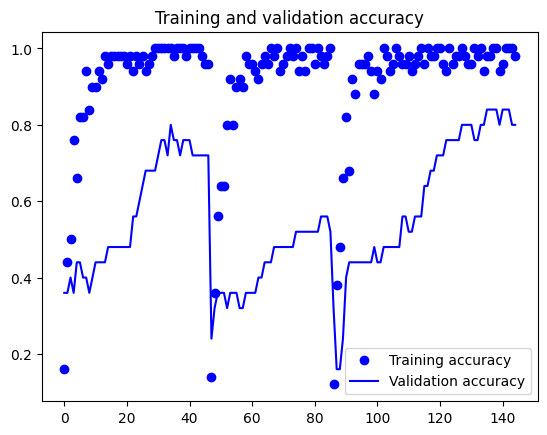

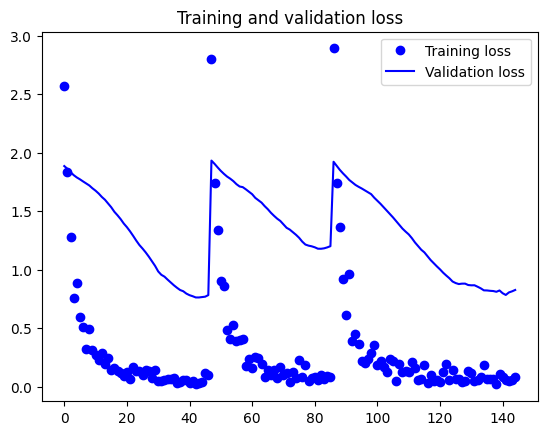

In [28]:
# Inicializar listas vacías para almacenar las métricas de todos los pliegues
all_accuracy = []
all_val_accuracy = []
all_loss = []
all_val_loss = []

# Iterar sobre los historiales de todos los pliegues
for history in histories:
    all_accuracy.extend(history['accuracy'])
    all_val_accuracy.extend(history['val_accuracy'])
    all_loss.extend(history['loss'])
    all_val_loss.extend(history['val_loss'])

# Calcular el número total de épocas (sumando los pliegues)
epochs = range(len(all_accuracy))

# Graficar precisión
plt.plot(epochs, all_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, all_val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Graficar pérdida
plt.plot(epochs, all_loss, 'bo', label='Training loss')
plt.plot(epochs, all_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


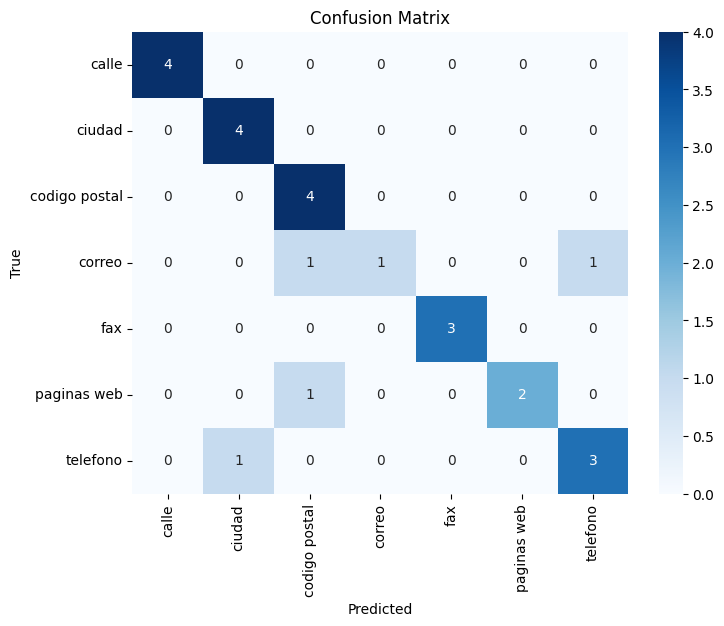

In [29]:
# Lista para almacenar las predicciones y las etiquetas verdaderas
all_predictions = []
all_true_labels = []

# Hacer predicciones en el conjunto de validación
predictions = model.predict(val_x_fold)
predicted_classes = np.argmax(predictions, axis=1)  # Obtener la clase con mayor probabilidad
true_classes = np.argmax(val_y_fold, axis=1)  # Obtener las clases verdaderas
    
# Almacenar las predicciones y las etiquetas verdaderas
all_predictions.extend(predicted_classes)
all_true_labels.extend(true_classes)

# Calcular la matriz de confusión
cm = confusion_matrix(all_true_labels, all_predictions)

# Mostrar la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Calcular y mostrar el classification report
report = classification_report(all_true_labels, all_predictions, target_names=classes)
print("Classification Report:\n", report)

Classification Report:
                precision    recall  f1-score   support

        calle       1.00      1.00      1.00         4
       ciudad       0.80      1.00      0.89         4
codigo postal       0.67      1.00      0.80         4
       correo       1.00      0.33      0.50         3
          fax       1.00      1.00      1.00         3
  paginas web       1.00      0.67      0.80         3
     telefono       0.75      0.75      0.75         4

     accuracy                           0.84        25
    macro avg       0.89      0.82      0.82        25
 weighted avg       0.87      0.84      0.83        25



In [31]:
# Guardar el modelo después de entrenar
model.save('chatbot_model_que_funciona.h5')